Acknowledgement: This project was largely motivated by the work of Michelle Lochner et al. (ApJ Supplement Series, 225:31, 2016), which can be accessed via this [link](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31).

In [199]:
# Note that this notebook was run on Google Colab,
# therefore, mounting it to Phong's Google Drive was necessary.
# If one runs it via Jupyter, this is not needed.
from google.colab import drive
drive.mount('/content/drive')

# When run locally via Jupyter, change dir to 'data/'
dir = '/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/data/' # Phong
#dir = '/content/drive/My Drive/ML_Fall2025_Supernovae/data/' # Valarie

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#adjust font sizes for visibility on slides
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
})

# Step 1: Data Analysis

## First, we load datasets of both models.

In [201]:
# Model 1:
I_Ia = pd.read_csv(dir + 'ML_master_table_TypeIa.csv').dropna()
I_Ibc = pd.read_csv(dir + 'ML_master_table_TypeIbc.csv').dropna()
I_II = pd.read_csv(dir + 'ML_master_table_TypeII.csv').dropna()
I_IIn = pd.read_csv(dir + 'master_ML_table_TypeIIn.csv').dropna()
I_skip = ['sn_name', 'sn_type', 'band']
I_labels = ['Ia', 'Ibc', 'II', 'IIn']

In [202]:
# Model 2:
II_Ia = pd.read_csv(dir + 'model2_typeIa_parameters.csv').dropna()
II_Ibc = pd.read_csv(dir + 'model2_typeIbc_parameters.csv').dropna()
II_II = pd.read_csv(dir + 'model2_typeII_parameters.csv').dropna()
II_IIn = pd.read_csv(dir + 'model2_typeIIn_parameters.csv').dropna()
II_skip = {'supernova', 'type', 'n_obs', 'flux_scale', 'redshift', 'band'}
II_labels = ['Ia', 'Ibc', 'II', 'IIn']

Next, we inspect the statistics of the features in each dataset.

In [203]:
def histogram_all(dfs, skip, labels):
    cols = [c for c in dfs[0].columns if c not in skip] #dfs[0].columns[2:] to show bands

    n = len(cols)
    rows = (n + 2) // 2    # number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]

        # Plot histograms from all three datasets
        for j in range(len(dfs)):
            ax.hist(dfs[j][column], bins=30, alpha=0.5, label=labels[j])

        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.legend()

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

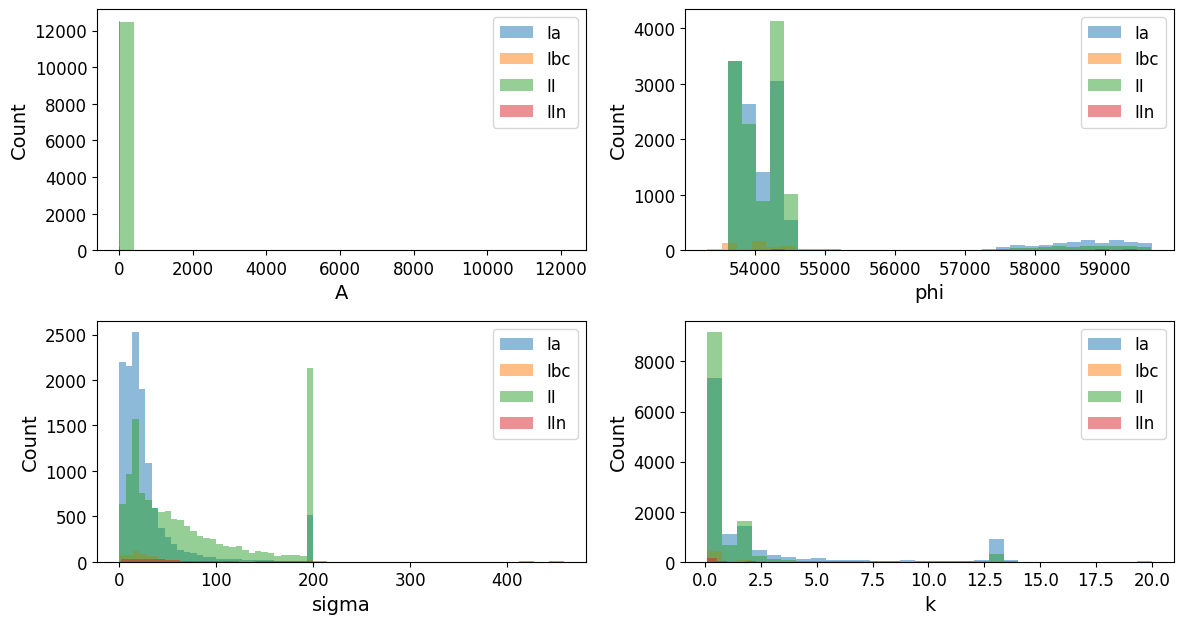

In [156]:
# Histograms for Model 1
histogram_all([I_Ia, I_Ibc, I_II, I_IIn], I_skip, I_labels)

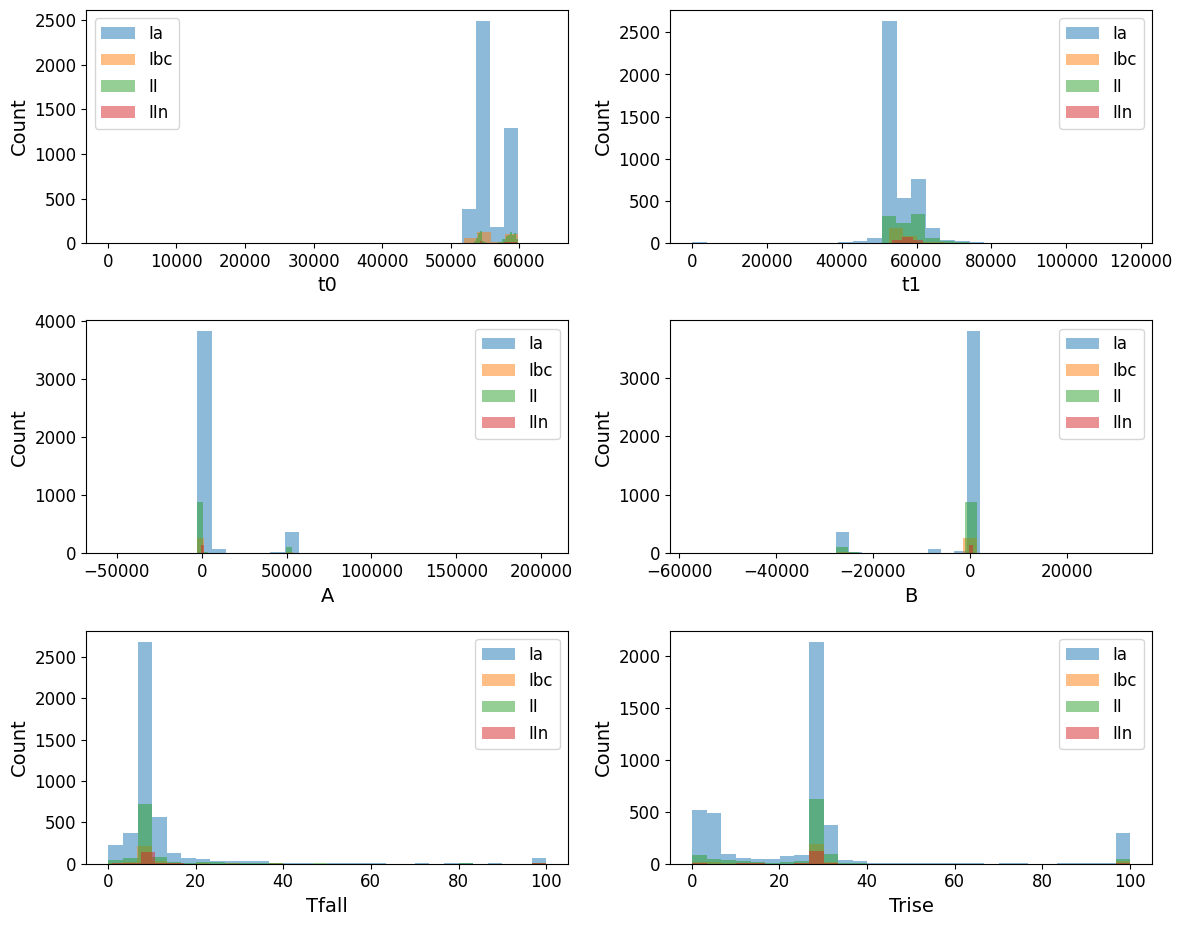

In [157]:
# Histograms for Model 2
histogram_all([II_Ia,II_Ibc,II_II,II_IIn],II_skip,II_labels)

Both these datasets show presence of outliers, which can skew the model. We use clipping technique to squeeze both dataset to their 25-75quantile intervals.

In [204]:
def clipping(dfs, skip):
    dfs_clipped = []
    feature_cols = dfs[0].columns[3:]

    for df in dfs:
        df_copy = df.copy()

        # Compute IQR only on feature columns
        Q1 = df_copy[feature_cols].quantile(0.25)
        Q3 = df_copy[feature_cols].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip only the feature columns
        df_copy[feature_cols] = df_copy[feature_cols].clip(lower=lower, upper=upper, axis=1)

        dfs_clipped.append(df_copy)

    return dfs_clipped

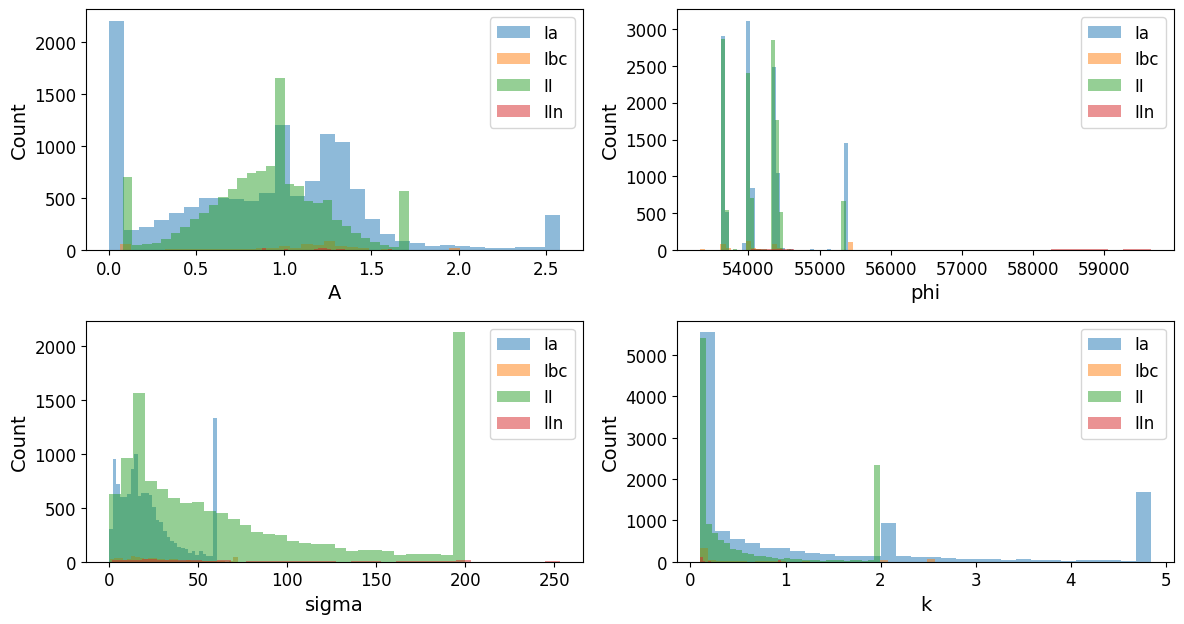

In [205]:
I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip = clipping([I_Ia,I_Ibc,I_II, I_IIn], I_skip)
histogram_all([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], I_skip, I_labels)

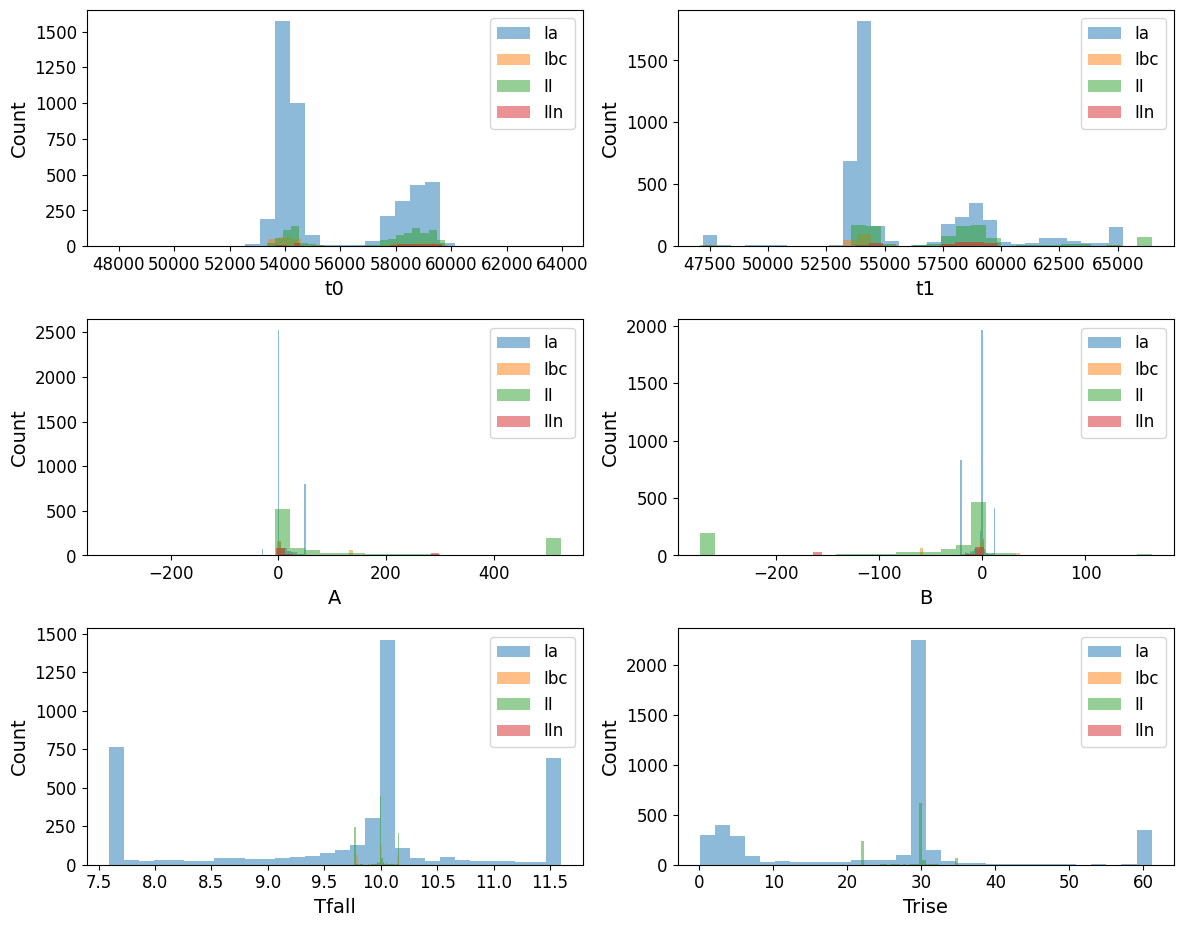

In [206]:
II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip = clipping([II_Ia,II_Ibc,II_II,II_IIn], II_skip)
histogram_all([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], II_skip, II_labels)

# Step 2: Prepare for training

In [207]:
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

## First, we define a function for evaluating performance of a model.

In [274]:
def evaluate_model(model, X_train, y_train, X_test, y_test, band_test, class_names=None, history=None):
  # -----------------------
  # Training set evaluation
  # -----------------------
  print("Training set:")
  if history is not None:  # Keras
    y_train_proba = model.predict(X_train)
    y_train_pred = np.argmax(y_train_proba, axis=1)
  else:
    if hasattr(model, "predict_proba"):
      y_train_proba = model.predict_proba(X_train)
      y_train_pred = np.argmax(y_train_proba, axis=1)
    else:
      y_train_pred = model.predict(X_train)  # labels only
      y_train_proba = label_binarize(y_train_pred, classes=np.unique(y_train))

  print("Accuracy:", accuracy_score(y_train, y_train_pred))
  print("\nClassification report:\n", classification_report(y_train, y_train_pred))
  print("\nConfusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  # -----------------------
  # Test set evaluation
  # -----------------------
  print("\nTest set:")
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)

  # Predict probabilities
  if history is not None:
    y_score = model.predict(X_test)
  else:
    if hasattr(model, "predict_proba"):
      y_score = model.predict_proba(X_test)

    elif hasattr(model, "decision_function"):
      dec = model.decision_function(X_test)

      # Ensure 2D
      if dec.ndim == 1:
        dec = np.vstack([-dec, dec]).T

      # Convert decision scores: pseudo-probabilities
      y_score = softmax(dec, axis=1)

    else:
      # completely fallback: use predicted labels as 0/1
      labels = model.predict(X_test)
      y_score = label_binarize(labels, classes=classes)

  # Ensure correct shape
  y_score = np.array(y_score)
  if y_score.shape[1] != n_classes:
    y_score = y_score[:, :n_classes]

  # Compute ROC thresholds
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  roc_thresholds = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Youden's J statistic
    J = tpr[i] - fpr[i]
    ix = np.argmax(J)
    roc_thresholds[i] = thresholds[ix]

  # Predict labels using ROC thresholds
  y_test_pred = np.full(X_test.shape[0], -1, dtype=int)  # -1 = uncertain (optional)

  not_classified = 0
  for j in range(X_test.shape[0]):
    above_thresh = [i for i in range(n_classes) if y_score[j, i] >= roc_thresholds[i]]
    if above_thresh:
      # choose class with highest probability among those exceeding threshold
      y_test_pred[j] = above_thresh[np.argmax([y_score[j, i] for i in above_thresh])]
    else:
      # fallback to most probable class
      # y_test_pred[j] = np.argmax(y_score[j, :])
      not_classified += 1

  print("\nNot classified:", not_classified)

  mask = y_test_pred != -1
  print("Accuracy:", accuracy_score(y_test[mask], y_test_pred[mask]))
  print("\nClassification report:\n", classification_report(y_test[mask], y_test_pred[mask]))
  print("\nConfusion matrix:\n", confusion_matrix(y_test[mask], y_test_pred[mask]))

  # -----------------------
  # Plot the ROC curves
  # -----------------------
  plt.figure(figsize=(7,6))

  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], lw=2, #color=colors(i),
             label=f'{label} (AUC = {roc_auc[i]:.2f})')#, Threshold = {roc_thresholds[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

  # ----------------------------------------------
  # Plot XGBClassifier train/val loss if available
  # ----------------------------------------------
  if hasattr(model, "evals_result"):
    try:
      results = model.evals_result()
    except:
      results = model.get_booster().evals_result()

    # print("\nEvals result keys:", results.keys())  # debug

    # mlogloss is your eval_metric
    train_key = list(results.keys())[0]
    val_key  = list(results.keys())[1]

    metric_name = list(results[train_key].keys())[0]

    train_loss = results[train_key][metric_name]
    val_loss   = results[val_key][metric_name]

    plt.figure(figsize=(7,6))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Boosting Rounds")
    plt.ylabel('Loss')
    plt.title("XGBoost Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  # ----------------------------------------------
  # Plot MLPClassifier train/val loss if available
  # ----------------------------------------------
  if history is not None:
    plt.figure(figsize=(7,6))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  if band_test is not None:
      print("\n==============================")
      print(" Per-band evaluation:")
      print("==============================")

      bands = sorted(band_test.unique())
      y_test_pred_all = model.predict(X_test)
      if history is not None:
          y_test_pred_all = np.argmax(y_test_pred_all, axis=1)

      for b in bands:
          idx = (band_test == b)
          y_true_b = y_test[idx]
          y_pred_b = y_test_pred_all[idx]

          print(f"\n--- Band = {b} ---")
          print("Count:", len(y_true_b))
          if len(y_true_b) == 0:
              print("No samples in this band.")
              continue

          print("Accuracy:", accuracy_score(y_true_b, y_pred_b))
          print(classification_report(y_true_b, y_pred_b))
          print("Confusion matrix:\n", confusion_matrix(y_true_b, y_pred_b))


## Second, we prepare features and labels.

In [209]:
# Model 1:
# Combining into a single dataset
I = pd.concat([I_Ia_clip, I_Ibc_clip, I_II_clip, I_IIn_clip], ignore_index=True)
I = I.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_feature_cols = [c for c in I.columns if c not in I_skip]
I_X = I[I_feature_cols]
I_band = I['band']

# Extracting labels
I_y = I['sn_type']
print("Unique mapped labels:", I_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, 2 for II, and 3 for IIn
I_name_Ia = ['Ia','IaQ','Ia_Pec']
I_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
I_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
I_y = I_y.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp, I_X_test, I_y_temp, I_y_test, I_band_temp, I_band_test = train_test_split(
    I_X, I_y, I_band,
    test_size=0.1,
    random_state=42,
    stratify=I_y,
    shuffle=True
)

I_X_train, I_X_val, I_y_train, I_y_val, I_band_train, I_band_val = train_test_split(
    I_X_temp, I_y_temp, I_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp,
    shuffle=True
)

I_scaler = RobustScaler()
I_X_train = I_scaler.fit_transform(I_X_train)
I_X_val = I_scaler.fit_transform(I_X_val)
I_X_test = I_scaler.transform(I_X_test)

# Compute weights
I_classes = np.unique(I_y_train)
I_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train
)
I_class_weights = dict(zip(I_classes, I_class_weights))
I_sample_weights = np.array([I_class_weights[label] for label in I_y_train])

# Count examples in classes
print("Total:\n",pd.Series(I_y).value_counts())
print("Train:\n",pd.Series(I_y_train).value_counts())
print("Validation:\n",pd.Series(I_y_val).value_counts())
print("Test:\n",pd.Series(I_y_test).value_counts())

Unique mapped labels: ['Ia' 'II' 'Ib_c' 'Ib' 'II_P' 'IaQ' 'IcQ' 'Ic_Pec' 'IIn' 'Ia_Pec' 'Ic'
 'IIP' 'II_L' 'IIQ' 'IIn_Pec' 'Ib-pec' 'IIn_LBV' 'II_Pec' 'Ic/Ic-BL']
Total:
 sn_type
0    12590
2    12447
1      600
3      199
Name: count, dtype: int64
Train:
 sn_type
0    8813
2    8713
1     420
3     139
Name: count, dtype: int64
Validation:
 sn_type
0    2518
2    2489
1     120
3      40
Name: count, dtype: int64
Test:
 sn_type
0    1259
2    1245
1      60
3      20
Name: count, dtype: int64


In [211]:
# Model 2:
# Combining into a single dataset
II = pd.concat([II_Ia_clip, II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II = II.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_feature_cols = [c for c in II.columns if c not in II_skip]
II_X = II[II_feature_cols]
II_band = II['band']

# Extracting labels
II_y = II['type']
print("Unique mapped labels:", II_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, 2 for II and 3 for IIn
II_name_Ia = ['Ia','IaQ','Ia_Pec']
II_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
II_name_IIn = ['IIn', 'IIn_LBV', 'IIn_Pec']
II_y = II_y.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data and scale
II_X_temp, II_X_test, II_y_temp, II_y_test, II_band_temp, II_band_test = train_test_split(
    II_X, II_y, II_band,
    test_size=0.1,
    random_state=42,
    stratify=II_y,
    shuffle=True
)

II_X_train, II_X_val, II_y_train, II_y_val, II_band_train, II_band_val = train_test_split(
    II_X_temp, II_y_temp, II_band_temp,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp,
    shuffle=True
)

II_scaler = RobustScaler()
II_X_train = II_scaler.fit_transform(II_X_train)
II_X_val = II_scaler.fit_transform(II_X_val)
II_X_test = II_scaler.transform(II_X_test)

# Compute weights
II_classes = np.unique(II_y_train)
II_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train
)
II_class_weights = dict(zip(II_classes, II_class_weights))
II_sample_weights = np.array([II_class_weights[label] for label in II_y_train])

# Count examples in classes
print("Total:\n",pd.Series(II_y).value_counts())
print("Train:\n",pd.Series(II_y_train).value_counts())
print("Validation:\n",pd.Series(II_y_val).value_counts())
print("Test:\n",pd.Series(II_y_test).value_counts())

Unique mapped labels: ['IIn' 'Ia' 'II_P' 'II' 'II_L' 'Ic' 'Ib' 'Ib_c' 'IIn_LBV' 'IaQ' 'Ic_Pec'
 'Ia_Pec' 'IIQ' 'II_Pec' 'IIn_Pec' 'IcQ']
Total:
 type
0    4365
2    1060
1     303
3     172
Name: count, dtype: int64
Train:
 type
0    3055
2     742
1     212
3     121
Name: count, dtype: int64
Validation:
 type
0    873
2    212
1     61
3     34
Name: count, dtype: int64
Test:
 type
0    437
2    106
1     30
3     17
Name: count, dtype: int64


It can be seen that both datasets have very strong imbalance between classes. We try downsampling.

In [212]:
# Model 1:
# Combining into a single dataset
I_down = pd.concat([I_Ia_clip.sample(1000), I_Ibc_clip, I_II_clip.sample(1000), I_IIn_clip], ignore_index=True)
I_down = I_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_X_down = I_down[I_feature_cols]
I_band_down = I_down['band']

# Extracting labels
I_y_down = I_down['sn_type']
#print("Unique mapped labels:", I_y_down.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, 2 for II and 3 for IIn
I_y_down = I_y_down.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else (3 if v in I_name_IIn else 1)))

# Split data into 70/20/10 and scale
I_X_temp_down, I_X_test_down, I_y_temp_down, I_y_test_down, I_band_temp_down, I_band_test_down = train_test_split(
    I_X_down, I_y_down, I_band_down,
    test_size=0.1,
    random_state=42,
    stratify=I_y_down,
    shuffle=True
)

I_X_train_down, I_X_val_down, I_y_train_down, I_y_val_down, I_band_train_down, I_band_val_down = train_test_split(
    I_X_temp_down, I_y_temp_down, I_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=I_y_temp_down,
    shuffle=True
)

I_scaler_down = RobustScaler()
I_X_train_down = I_scaler_down.fit_transform(I_X_train_down)
I_X_val_down = I_scaler_down.fit_transform(I_X_val_down)
I_X_test_down = I_scaler_down.transform(I_X_test_down)

# Compute weights
I_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=I_classes,
    y=I_y_train_down
)
I_class_weights_down = dict(zip(I_classes, I_class_weights_down))
I_sample_weights_down = np.array([I_class_weights_down[label] for label in I_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(I_y_down).value_counts())
print("Train:\n",pd.Series(I_y_train_down).value_counts())
print("Validation:\n",pd.Series(I_y_val_down).value_counts())
print("Test:\n",pd.Series(I_y_test_down).value_counts())

Total:
 sn_type
0    1000
2    1000
1     600
3     199
Name: count, dtype: int64
Train:
 sn_type
2    700
0    700
1    420
3    139
Name: count, dtype: int64
Validation:
 sn_type
2    200
0    200
1    120
3     40
Name: count, dtype: int64
Test:
 sn_type
2    100
0    100
1     60
3     20
Name: count, dtype: int64


In [213]:
# Model 2:
# Combining into a single dataset
II_down = pd.concat([II_Ia_clip.sample(2000), II_Ibc_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II_down = II_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_X_down = II_down[II_feature_cols]
II_band_down = II_down['band']

# Extracting labels
II_y_down = II_down['type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, 2 for II and 3 for IIn
II_y_down = II_y_down.apply(lambda v: 0 if v in II_name_Ia else (2 if v in II_name_II else (3 if v in II_name_IIn else 1)))

# Split data into 70/20/10 and scale
II_X_temp_down, II_X_test_down, II_y_temp_down, II_y_test_down, II_band_temp_down, II_band_test_down = train_test_split(
    II_X_down, II_y_down, II_band_down,
    test_size=0.1,
    random_state=42,
    stratify=II_y_down,
    shuffle=True
)

II_X_train_down, II_X_val_down, II_y_train_down, II_y_val_down, II_band_train_down, II_band_val_down = train_test_split(
    II_X_temp_down, II_y_temp_down, II_band_temp_down,
    test_size=0.2222, #1 - (70/90) gives 20% split relative to full data set
    random_state=42,
    stratify=II_y_temp_down,
    shuffle=True
)

II_scaler_down = RobustScaler()
II_X_train_down = II_scaler_down.fit_transform(II_X_train_down)
II_X_val_down = II_scaler_down.fit_transform(II_X_val_down)
II_X_test_down = II_scaler_down.transform(II_X_test_down)

# Compute weights
II_class_weights_down = compute_class_weight(
    class_weight='balanced',
    classes=II_classes,
    y=II_y_train_down
)
II_class_weights_down = dict(zip(II_classes, II_class_weights_down))
II_sample_weights_down = np.array([II_class_weights_down[label] for label in II_y_train_down])

# Count examples in classes
print("Total:\n",pd.Series(II_y_down).value_counts())
print("Train:\n",pd.Series(II_y_train_down).value_counts())
print("Validation:\n",pd.Series(II_y_val_down).value_counts())
print("Test:\n",pd.Series(II_y_test_down).value_counts())

Total:
 type
0    2000
2    1060
1     303
3     172
Name: count, dtype: int64
Train:
 type
0    1400
2     742
1     211
3     121
Name: count, dtype: int64
Validation:
 type
0    400
2    212
1     61
3     34
Name: count, dtype: int64
Test:
 type
0    200
2    106
1     31
3     17
Name: count, dtype: int64


# Step 3: Multi-layer perceptron classifier

In [224]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Model 1

Epoch 1/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3922 - loss: 1.7778 - val_accuracy: 0.4925 - val_loss: 1.0338
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4533 - loss: 1.3548 - val_accuracy: 0.5249 - val_loss: 0.9823
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4834 - loss: 1.0935 - val_accuracy: 0.5338 - val_loss: 0.9591
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4973 - loss: 1.0623 - val_accuracy: 0.5287 - val_loss: 0.9557
Epoch 5/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5066 - loss: 1.0492 - val_accuracy: 0.5409 - val_loss: 0.9316
Epoch 6/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5052 - loss: 0.9706 - val_accuracy: 0.5715 - val_loss: 0.9188
Epoch 7/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5344 - loss: 0.9098 - val_accuracy: 0.5164 - val_loss: 0.9673
Epoch 8/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5201 - loss: 0.9099 - val_accuracy: 0

/tmp/ipython-input-989330651.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


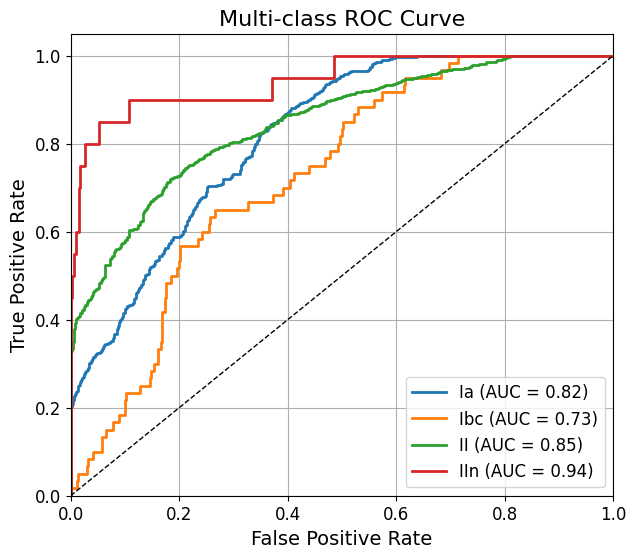

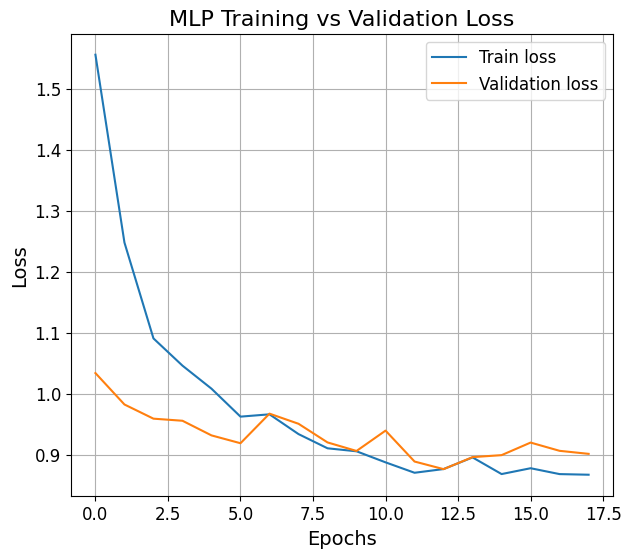


 Per-band evaluation:
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Band = G ---
Count: 226
Accuracy: 0.19911504424778761
              precision    recall  f1-score   support

           0       0.96      0.17      0.28       144
           1       0.03      0.86      0.06         7
           2       0.75      0.09      0.16        66
           3       0.69      1.00      0.82         9

    accuracy                           0.20       226
   macro avg       0.61      0.53      0.33       226
weighted avg       0.86      0.20      0.26       226

Confusion matrix:
 [[ 24 118   2   0]
 [  1   6   0   0]
 [  0  56   6   4]
 [  0   0   0   9]]

--- Band = g' ---
Count: 436
Accuracy: 0.5756880733944955
              precision    recall  f1-score   support

           0       0.84      0.40      0.54       211
           1       0.02      0.50      0.04         6
           2       0.86      0.75      0.80       217
           3       0.10      0.50      0.17         2

    accuracy     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [229]:
# Model 1 without downsampling
I_mlp = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

I_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history = I_mlp.fit(
    I_X_train, I_y_train,
    validation_data=(I_X_val, I_y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=I_class_weights
)

evaluate_model(I_mlp, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels, I_history)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.2248 - loss: 2.2265 - val_accuracy: 0.2607 - val_loss: 1.3548
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3395 - loss: 1.5735 - val_accuracy: 0.4107 - val_loss: 1.2875
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4037 - loss: 1.3659 - val_accuracy: 0.4107 - val_loss: 1.2261
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4369 - loss: 1.2493 - val_accuracy: 0.4357 - val_loss: 1.1715
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4416 - loss: 1.1553 - val_accuracy: 0.4518 - val_loss: 1.1256
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4704 - loss: 1.1064 - val_accuracy: 0.4643 - val_loss: 1.0896
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4677 - loss: 1.1098 - val_accuracy: 0.4786 - val_loss: 1.0627
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4717 - loss: 1.1243 - val_accuracy: 0.4964 - va

/tmp/ipython-input-989330651.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


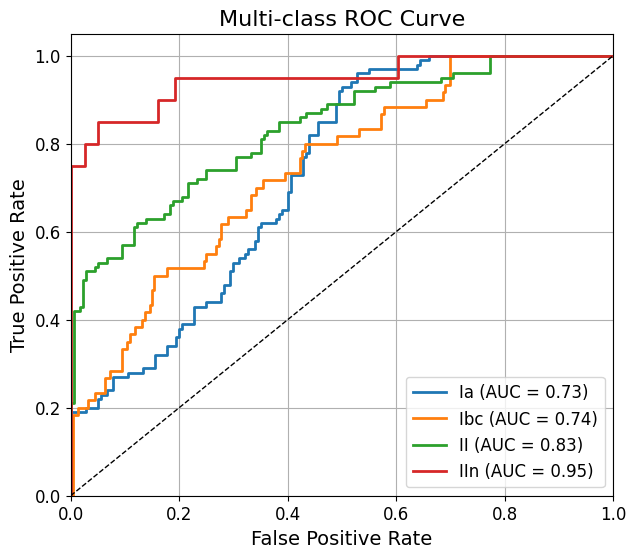

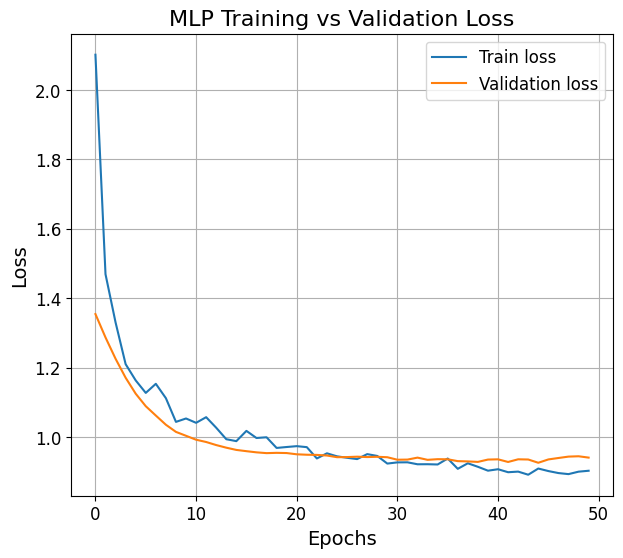


 Per-band evaluation:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Band = G ---
Count: 51
Accuracy: 0.5294117647058824
              precision    recall  f1-score   support

           0       0.33      0.06      0.11        16
           1       0.35      0.86      0.50        14
           2       0.00      0.00      0.00         7
           3       1.00      1.00      1.00        14

    accuracy                           0.53        51
   macro avg       0.42      0.48      0.40        51
weighted avg       0.48      0.53      0.44        51

Confusion matrix:
 [[ 1 15  0  0]
 [ 2 12  0  0]
 [ 0  7  0  0]
 [ 0  0  0 14]]

--- Band = g' ---
Count: 38
Accuracy: 0.42105263157894735
              precision    recall  f1-score   support

           0       0.35      0.43      0.39        14
           1       0.29      0.44      0.35         9
           2       0.86      0.46      0.60        13
           3       0.00      0.00      0.00         2

    accuracy                        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [253]:
# Model 1 with downsampling
I_mlp_down = models.Sequential([
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

I_mlp_down.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history_down = I_mlp_down.fit(
    I_X_train_down, I_y_train_down,
    validation_data=(I_X_val_down, I_y_val_down),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    class_weight=I_class_weights_down
)

evaluate_model(I_mlp_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels, I_history_down)

## Model 2

Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2568 - loss: 1.8151 - val_accuracy: 0.4288 - val_loss: 1.1690
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3708 - loss: 1.4141 - val_accuracy: 0.4559 - val_loss: 1.1365
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4167 - loss: 1.2452 - val_accuracy: 0.4661 - val_loss: 1.1167
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4418 - loss: 1.3004 - val_accuracy: 0.4729 - val_loss: 1.0577
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4757 - loss: 1.2360 - val_accuracy: 0.4737 - val_loss: 1.0446
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4882 - loss: 1.2428 - val_accuracy: 0.4686 - val_loss: 1.0732
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4808 - loss: 1.2324 - val_accuracy: 0.4856 - val_loss: 1.0014
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5142 - loss: 1.0878 - val_accuracy: 

/tmp/ipython-input-989330651.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


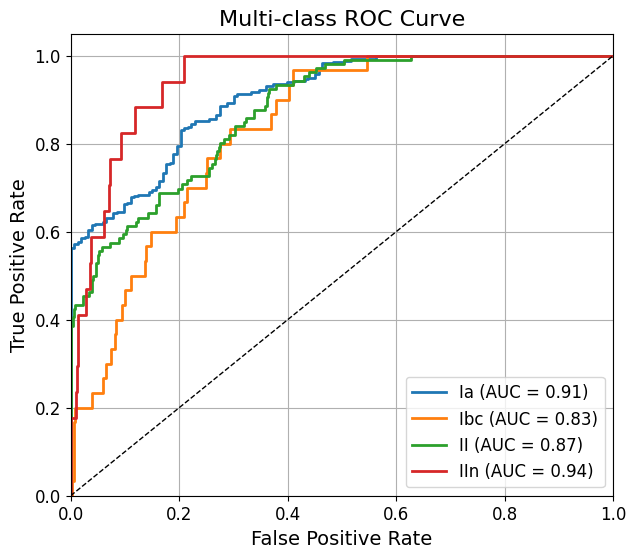

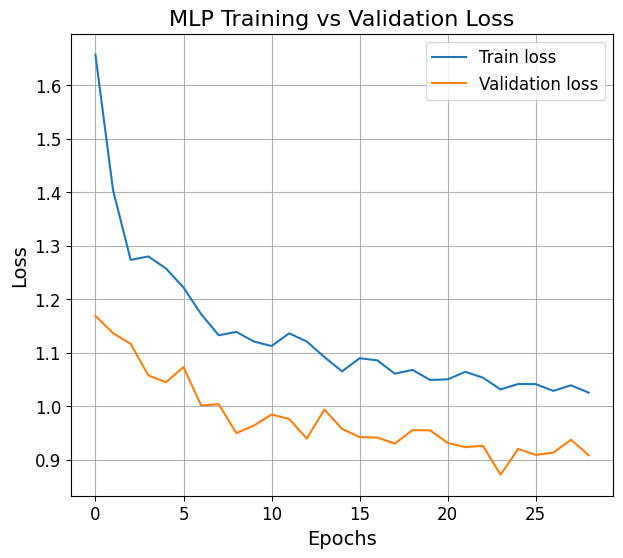


 Per-band evaluation:
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Band = G ---
Count: 225
Accuracy: 0.4711111111111111
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       136
           1       1.00      0.18      0.31        11
           2       1.00      0.43      0.60        63
           3       0.11      1.00      0.20        15

    accuracy                           0.47       225
   macro avg       0.78      0.52      0.43       225
weighted avg       0.94      0.47      0.58       225

Confusion matrix:
 [[62  0  0 74]
 [ 0  2  0  9]
 [ 0  0 27 36]
 [ 0  0  0 15]]

--- Band = g' ---
Count: 61
Accuracy: 0.5245901639344263
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        52
           1       0.04      1.00      0.07         1
           2       1.00      0.38      0.55         8
           3       0.00      0.00      0.00         0

    accuracy                      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

In [265]:
# Model 2 without downsampling
II_mlp = models.Sequential([
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

II_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history = II_mlp.fit(
    II_X_train, II_y_train,
    validation_data=(II_X_val, II_y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=II_class_weights
)

evaluate_model(II_mlp, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test,II_labels, II_history)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2348 - loss: 1.6124 - val_accuracy: 0.3579 - val_loss: 1.1681
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2947 - loss: 1.4577 - val_accuracy: 0.4498 - val_loss: 1.0878
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3355 - loss: 1.3254 - val_accuracy: 0.4851 - val_loss: 1.0449
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3466 - loss: 1.2628 - val_accuracy: 0.4809 - val_loss: 1.0314
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3773 - loss: 1.2347 - val_accuracy: 0.4908 - val_loss: 1.0213
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3801 - loss: 1.2351 - val_accuracy: 0.4880 - val_loss: 1.0111
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3961 - loss: 1.2211 - val_accuracy: 0.4795 - val_loss: 1.0118
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4029 - loss: 1.1923 - val_accuracy: 0.4936 - v

/tmp/ipython-input-989330651.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


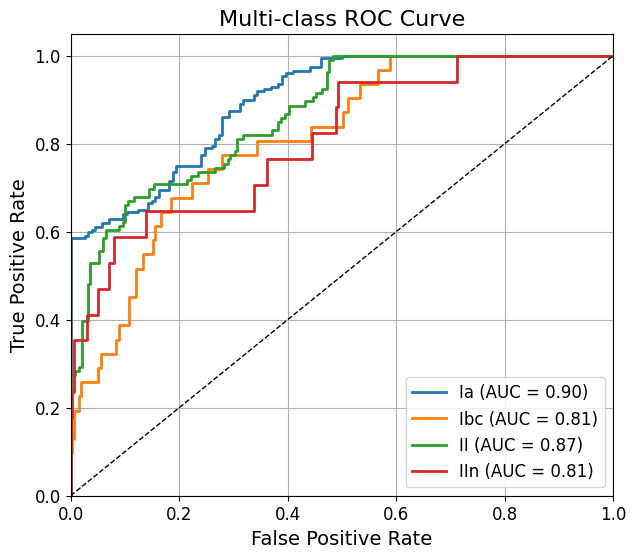

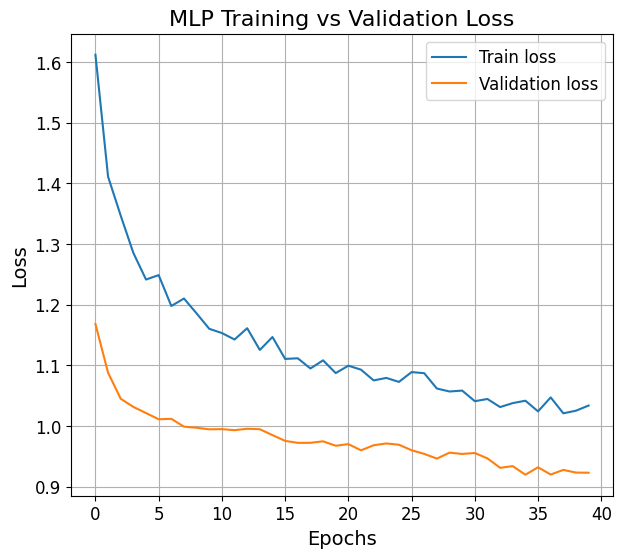


 Per-band evaluation:
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

--- Band = G ---
Count: 152
Accuracy: 0.5131578947368421
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        72
           1       0.17      0.25      0.20         8
           2       0.94      0.52      0.67        61
           3       0.14      0.91      0.24        11

    accuracy                           0.51       152
   macro avg       0.56      0.54      0.44       152
weighted avg       0.87      0.51      0.60       152

Confusion matrix:
 [[34  9  1 28]
 [ 0  2  0  6]
 [ 0  1 32 28]
 [ 0  0  1 10]]

--- Band = g' ---
Count: 36
Accuracy: 0.4722222222222222
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        24
           1       0.10      1.00      0.17         2
           2       1.00      0.33      0.50         9
           3       0.00      0.00      0.00         1

    accuracy                      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [271]:
# Model 2 with downsampling
II_mlp_down = models.Sequential([
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

II_mlp_down.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history_down = II_mlp_down.fit(
    II_X_train_down, II_y_train_down,
    validation_data=(II_X_val_down, II_y_val_down),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=II_class_weights_down
)

evaluate_model(II_mlp_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels, II_history_down)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

# Step 4: Support vector machine classifier

In [272]:
from sklearn.svm import SVC

## Model 1

Training set:
Accuracy: 0.7727398396461156

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79      8813
           1       0.00      0.00      0.00       420
           2       0.81      0.74      0.78      8713
           3       0.00      0.00      0.00       139

    accuracy                           0.77     18085
   macro avg       0.39      0.40      0.39     18085
weighted avg       0.75      0.77      0.76     18085


Confusion matrix:
 [[7527    0 1286    0]
 [ 325    0   95    0]
 [2262    0 6448    3]
 [  41    1   97    0]]

Test set:

Not classified: 4
Accuracy: 0.7732558139534884

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80      1257
           1       0.17      0.05      0.08        60
           2       0.84      0.71      0.77      1243
           3       0.33      0.35      0.34        20

    accuracy                

/tmp/ipython-input-4070249860.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


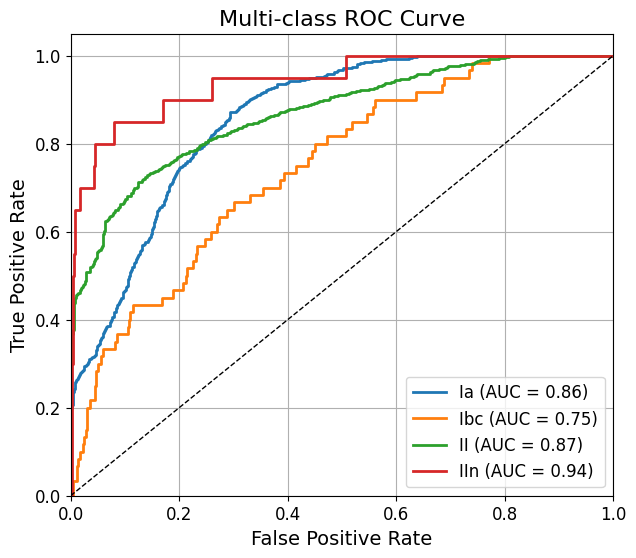


 Per-band evaluation:

--- Band = G ---
Count: 226
Accuracy: 0.18141592920353983
              precision    recall  f1-score   support

           0       0.92      0.16      0.27       144
           1       0.04      1.00      0.07         7
           2       1.00      0.03      0.06        66
           3       0.90      1.00      0.95         9

    accuracy                           0.18       226
   macro avg       0.71      0.55      0.34       226
weighted avg       0.92      0.18      0.23       226

Confusion matrix:
 [[ 23 121   0   0]
 [  0   7   0   0]
 [  2  61   2   1]
 [  0   0   0   9]]

--- Band = g' ---
Count: 436
Accuracy: 0.555045871559633
              precision    recall  f1-score   support

           0       0.74      0.49      0.59       211
           1       0.02      0.33      0.03         6
           2       0.93      0.63      0.75       217
           3       0.03      0.50      0.06         2

    accuracy                           0.56       436
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [279]:
# Model 1 without downsampling
I_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm.fit(I_X_train, I_y_train)
evaluate_model(I_svm, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels)

Training set:
Accuracy: 0.6013272077590608

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.63      0.59       700
           1       0.44      0.45      0.44       420
           2       0.71      0.66      0.68       700
           3       0.97      0.65      0.78       139

    accuracy                           0.60      1959
   macro avg       0.67      0.60      0.62      1959
weighted avg       0.62      0.60      0.61      1959


Confusion matrix:
 [[438 160 102   0]
 [161 189  70   0]
 [173  64 460   3]
 [ 11  19  18  91]]

Test set:

Not classified: 0
Accuracy: 0.5892857142857143

Classification report:
               precision    recall  f1-score   support

           0       0.51      0.60      0.55       100
           1       0.41      0.50      0.45        60
           2       0.80      0.61      0.69       100
           3       1.00      0.70      0.82        20

    accuracy                           0.59 

/tmp/ipython-input-4070249860.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


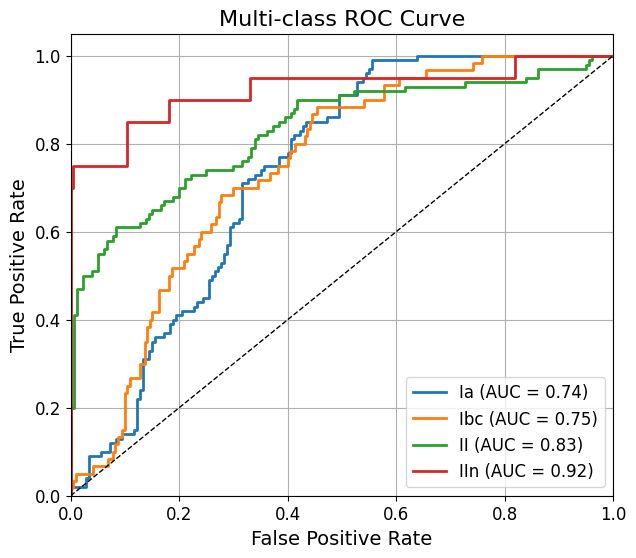


 Per-band evaluation:

--- Band = G ---
Count: 51
Accuracy: 0.5686274509803921
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.39      1.00      0.56        14
           2       0.00      0.00      0.00         7
           3       1.00      1.00      1.00        14

    accuracy                           0.57        51
   macro avg       0.60      0.52      0.42        51
weighted avg       0.69      0.57      0.47        51

Confusion matrix:
 [[ 1 15  0  0]
 [ 0 14  0  0]
 [ 0  7  0  0]
 [ 0  0  0 14]]

--- Band = g' ---
Count: 38
Accuracy: 0.47368421052631576
              precision    recall  f1-score   support

           0       0.41      0.50      0.45        14
           1       0.36      0.56      0.43         9
           2       0.86      0.46      0.60        13
           3       0.00      0.00      0.00         2

    accuracy                           0.47        38
   macro avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [278]:
# Model 1 with downsampling
I_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm_down.fit(I_X_train_down, I_y_train_down)
evaluate_model(I_svm_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels)

## Model 2

Training set:
Accuracy: 0.7951573849878935

Classification report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89      3055
           1       0.29      0.01      0.02       212
           2       0.70      0.31      0.43       742
           3       0.00      0.00      0.00       121

    accuracy                           0.80      4130
   macro avg       0.45      0.33      0.34      4130
weighted avg       0.74      0.80      0.74      4130


Confusion matrix:
 [[3049    0    6    0]
 [ 158    2   52    0]
 [ 505    4  233    0]
 [  79    1   41    0]]

Test set:

Not classified: 0
Accuracy: 0.5915254237288136

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73       437
           1       0.07      0.03      0.04        30
           2       0.30      0.93      0.46       106
           3       0.00      0.00      0.00        17

    accuracy                

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

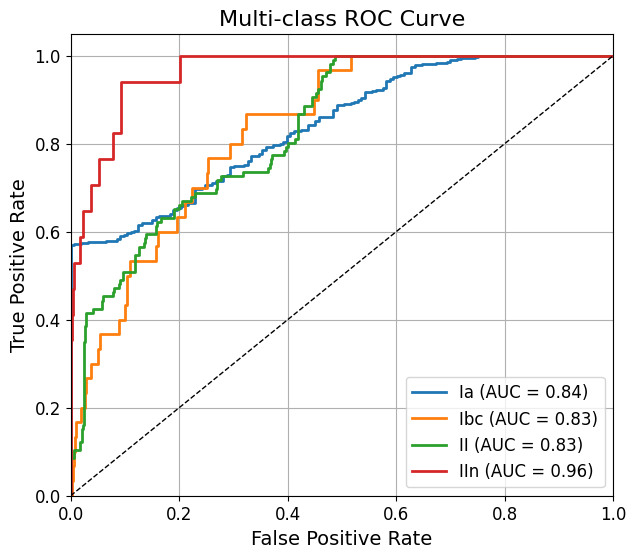


 Per-band evaluation:

--- Band = G ---
Count: 225
Accuracy: 0.4577777777777778
              precision    recall  f1-score   support

           0       1.00      0.43      0.60       136
           1       0.44      0.36      0.40        11
           2       1.00      0.43      0.60        63
           3       0.11      0.93      0.19        15

    accuracy                           0.46       225
   macro avg       0.64      0.54      0.45       225
weighted avg       0.91      0.46      0.56       225

Confusion matrix:
 [[58  0  0 78]
 [ 0  4  0  7]
 [ 0  4 27 32]
 [ 0  1  0 14]]

--- Band = g' ---
Count: 61
Accuracy: 0.5245901639344263
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        52
           1       0.04      1.00      0.07         1
           2       0.80      0.50      0.62         8
           3       0.00      0.00      0.00         0

    accuracy                           0.52        61
   macro avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [280]:
# Model 2 without downsampling
II_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm.fit(II_X_train, II_y_train)
evaluate_model(II_svm, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test, II_labels)

Training set:
Accuracy: 0.6996766370250607

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.90      0.81      1400
           1       0.67      0.04      0.07       211
           2       0.62      0.63      0.63       742
           3       0.00      0.00      0.00       121

    accuracy                           0.70      2474
   macro avg       0.51      0.39      0.38      2474
weighted avg       0.66      0.70      0.65      2474


Confusion matrix:
 [[1254    2  144    0]
 [ 135    8   68    0]
 [ 272    1  469    0]
 [  49    1   71    0]]

Test set:

Not classified: 1
Accuracy: 0.6798866855524079

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       199
           1       0.50      0.45      0.47        31
           2       0.83      0.59      0.69       106
           3       0.09      0.29      0.14        17

    accuracy                

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-4070249860.py:96: MatplotlibDe

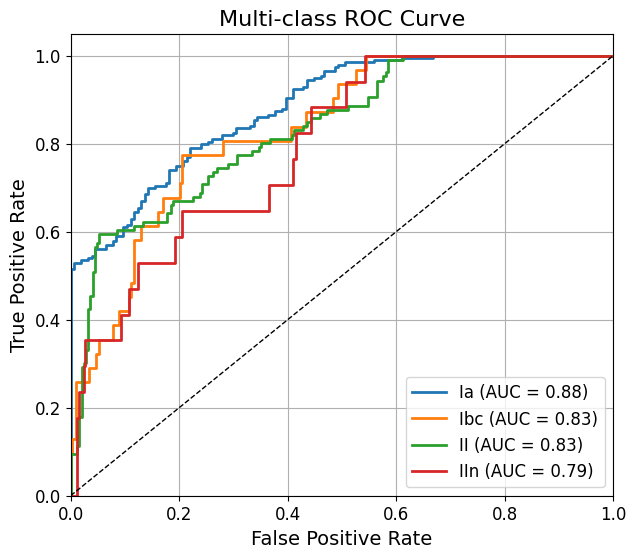


 Per-band evaluation:

--- Band = G ---
Count: 152
Accuracy: 0.39473684210526316
              precision    recall  f1-score   support

           0       1.00      0.42      0.59        72
           1       0.17      0.12      0.14         8
           2       0.95      0.31      0.47        61
           3       0.10      0.91      0.19        11

    accuracy                           0.39       152
   macro avg       0.56      0.44      0.35       152
weighted avg       0.87      0.39      0.49       152

Confusion matrix:
 [[30  0  1 41]
 [ 0  1  0  7]
 [ 0  4 19 38]
 [ 0  1  0 10]]

--- Band = g' ---
Count: 36
Accuracy: 0.4166666666666667
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        24
           1       0.09      1.00      0.17         2
           2       1.00      0.11      0.20         9
           3       0.00      0.00      0.00         1

    accuracy                           0.42        36
   macro avg       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [281]:
# Model 2 with downsampling
II_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm_down.fit(II_X_train_down, II_y_train_down)
evaluate_model(II_svm_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

# Step 5: Boosted decision tree classifier

In [25]:
from xgboost import XGBClassifier

## Model 1

Training set:
Accuracy: 0.7828034282554603

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      8813
           1       0.15      0.69      0.25       420
           2       0.94      0.75      0.84      8713
           3       0.49      0.86      0.62       139

    accuracy                           0.78     18085
   macro avg       0.60      0.78      0.63     18085
weighted avg       0.85      0.78      0.81     18085


Confusion matrix:
 [[7182 1185  395   51]
 [ 110  288   16    6]
 [1676  402 6568   67]
 [  13    2    5  119]]

Test set:

Not classified: 0
Accuracy: 0.6505417956656346

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.91      0.75      1259
           1       0.04      0.12      0.06        60
           2       0.95      0.41      0.58      1245
           3       0.17      0.65      0.27        20

    accuracy                

/tmp/ipython-input-4070249860.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


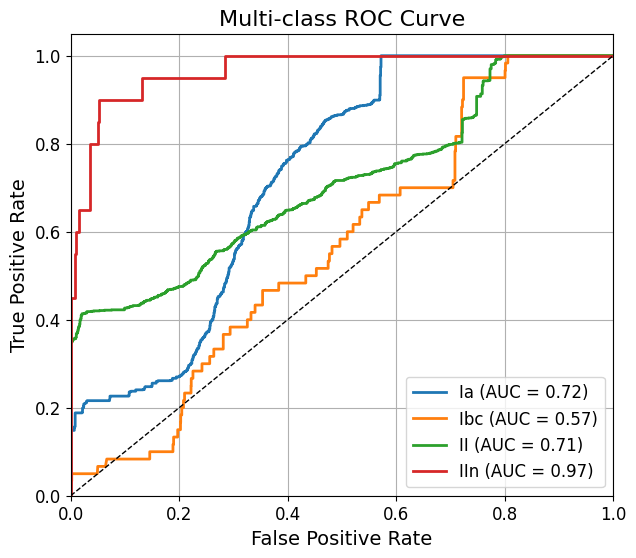

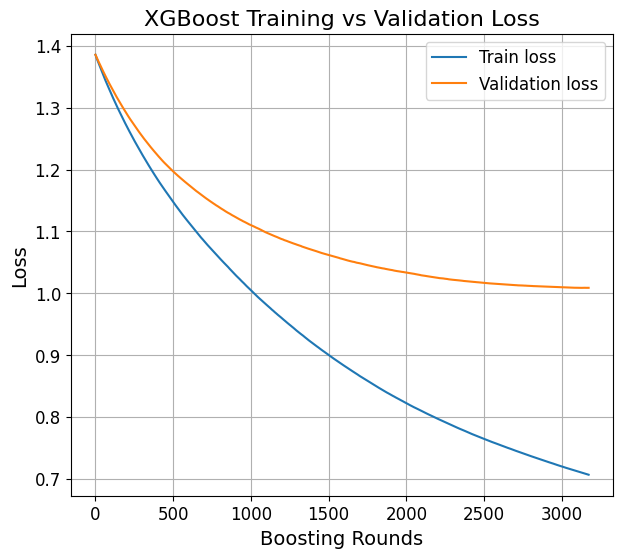


 Per-band evaluation:

--- Band = G ---
Count: 226
Accuracy: 0.11061946902654868
              precision    recall  f1-score   support

           0       0.23      0.08      0.12       144
           1       0.00      0.00      0.00         7
           2       0.04      0.08      0.05        66
           3       0.26      1.00      0.41         9

    accuracy                           0.11       226
   macro avg       0.13      0.29      0.14       226
weighted avg       0.17      0.11      0.10       226

Confusion matrix:
 [[ 11   7 126   0]
 [  7   0   0   0]
 [ 29   6   5  26]
 [  0   0   0   9]]

--- Band = g' ---
Count: 436
Accuracy: 0.6995412844036697
              precision    recall  f1-score   support

           0       0.68      0.85      0.75       211
           1       0.00      0.00      0.00         6
           2       0.92      0.58      0.71       217
           3       0.00      0.00      0.00         2

    accuracy                           0.70       436
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [351]:
# Model 1 without downsampling
I_bdt = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    min_child_weight=3,
    subsample=0.6,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

I_bdt.fit(I_X_train, I_y_train,
          sample_weight=I_sample_weights,
          eval_set=[(I_X_train, I_y_train),(I_X_val, I_y_val)],
          verbose=False)
evaluate_model(I_bdt, I_X_train, I_y_train, I_X_test, I_y_test, I_band_test, I_labels)

Training set:
Accuracy: 0.7942827973455845

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.83      0.78       700
           1       0.68      0.75      0.71       420
           2       0.95      0.75      0.84       700
           3       0.86      0.96      0.91       139

    accuracy                           0.79      1959
   macro avg       0.81      0.82      0.81      1959
weighted avg       0.81      0.79      0.80      1959


Confusion matrix:
 [[584 100  16   0]
 [ 86 313  11  10]
 [120  43 526  11]
 [  2   2   2 133]]

Test set:

Not classified: 0
Accuracy: 0.6321428571428571

Classification report:
               precision    recall  f1-score   support

           0       0.53      0.72      0.61       100
           1       0.57      0.55      0.56        60
           2       0.86      0.55      0.67       100
           3       0.74      0.85      0.79        20

    accuracy                           0.63 

/tmp/ipython-input-4070249860.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


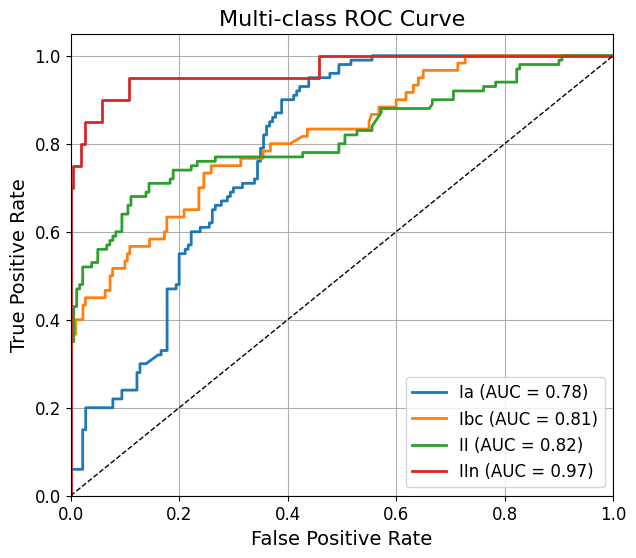

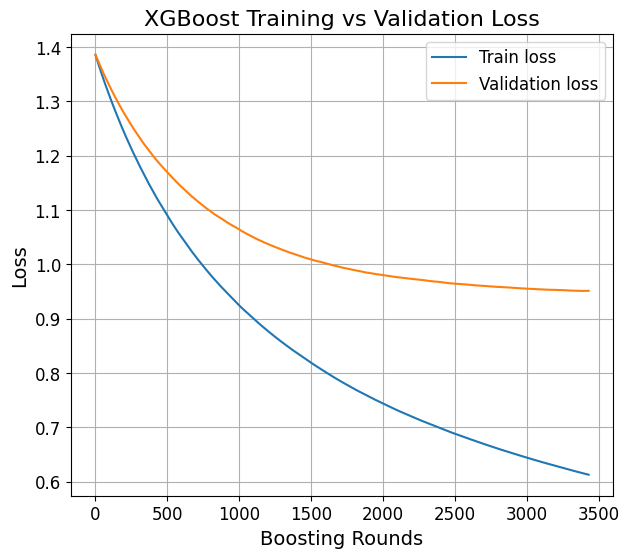


 Per-band evaluation:

--- Band = G ---
Count: 51
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00        14

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

Confusion matrix:
 [[16  0  0  0]
 [ 0 14  0  0]
 [ 0  0  7  0]
 [ 0  0  0 14]]

--- Band = g' ---
Count: 38
Accuracy: 0.39473684210526316
              precision    recall  f1-score   support

           0       0.35      0.50      0.41        14
           1       0.27      0.33      0.30         9
           2       0.71      0.38      0.50        13
           3       0.00      0.00      0.00         2

    accuracy                           0.39        38
   macro avg       0.33      0.30  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [355]:
# Model 1 with downsampling
I_bdt_down = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=4,
    subsample=0.6,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

I_bdt_down.fit(I_X_train_down, I_y_train_down,
               sample_weight=I_sample_weights_down,
               eval_set=[(I_X_train_down, I_y_train_down),(I_X_test_down, I_y_test_down)],
               verbose=False)
evaluate_model(I_bdt_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_band_test_down, I_labels)

## Model 2

Training set:
Accuracy: 0.962227602905569

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      3055
           1       0.88      1.00      0.94       212
           2       0.89      0.97      0.93       742
           3       0.86      1.00      0.92       121

    accuracy                           0.96      4130
   macro avg       0.91      0.98      0.94      4130
weighted avg       0.97      0.96      0.96      4130


Confusion matrix:
 [[2919   27   89   20]
 [   0  212    0    0]
 [  19    1  722    0]
 [   0    0    0  121]]

Test set:

Not classified: 1
Accuracy: 0.7402376910016978

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       436
           1       0.32      0.63      0.43        30
           2       0.52      0.77      0.62       106
           3       0.15      0.18      0.16        17

    accuracy                 

/tmp/ipython-input-4070249860.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


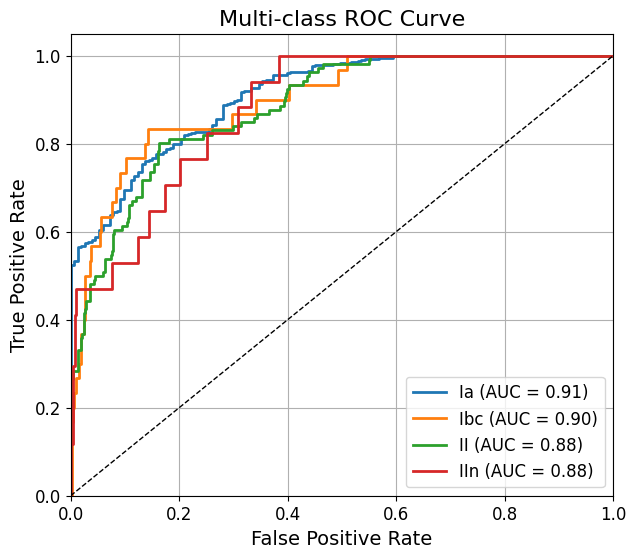

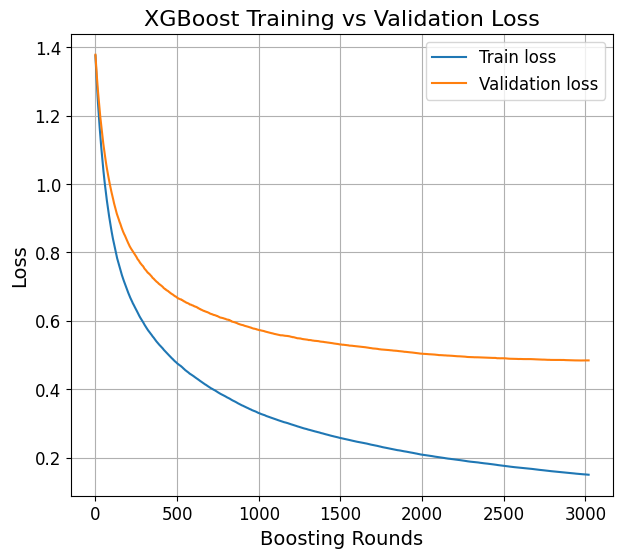


 Per-band evaluation:

--- Band = G ---
Count: 225
Accuracy: 0.7733333333333333
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       136
           1       0.67      0.18      0.29        11
           2       0.61      0.79      0.69        63
           3       1.00      0.13      0.24        15

    accuracy                           0.77       225
   macro avg       0.79      0.50      0.52       225
weighted avg       0.80      0.77      0.75       225

Confusion matrix:
 [[120   0  16   0]
 [  3   2   6   0]
 [ 12   1  50   0]
 [  3   0  10   2]]

--- Band = g' ---
Count: 61
Accuracy: 0.8688524590163934
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        52
           1       0.25      1.00      0.40         1
           2       0.67      0.50      0.57         8

    accuracy                           0.87        61
   macro avg       0.62      0.81      0.63        61
weig

In [321]:
# Model 2 without downsampling
II_bdt = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=4,
    min_child_weight=3,
    subsample=0.6,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

II_bdt.fit(II_X_train, II_y_train,
           sample_weight=II_sample_weights,
           eval_set=[(II_X_train, II_y_train),(II_X_val, II_y_val)],
           verbose=False)
evaluate_model(II_bdt, II_X_train, II_y_train, II_X_test, II_y_test, II_band_test, II_labels)

Training set:
Accuracy: 0.8860145513338723

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      1400
           1       0.70      0.95      0.81       211
           2       0.91      0.85      0.88       742
           3       0.58      1.00      0.73       121

    accuracy                           0.89      2474
   macro avg       0.79      0.92      0.84      2474
weighted avg       0.91      0.89      0.89      2474


Confusion matrix:
 [[1238   59   61   42]
 [   3  200    5    3]
 [  40   25  633   44]
 [   0    0    0  121]]

Test set:

Not classified: 0
Accuracy: 0.6129943502824858

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.56      0.72       200
           1       0.23      0.52      0.31        31
           2       0.61      0.76      0.68       106
           3       0.19      0.41      0.26        17

    accuracy                

/tmp/ipython-input-4070249860.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


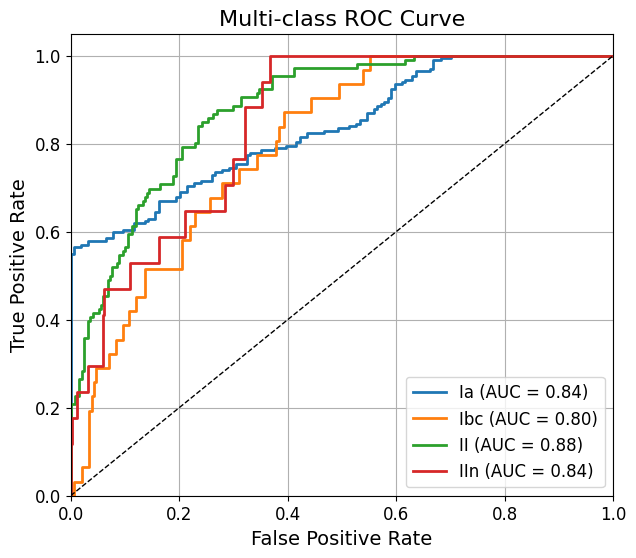

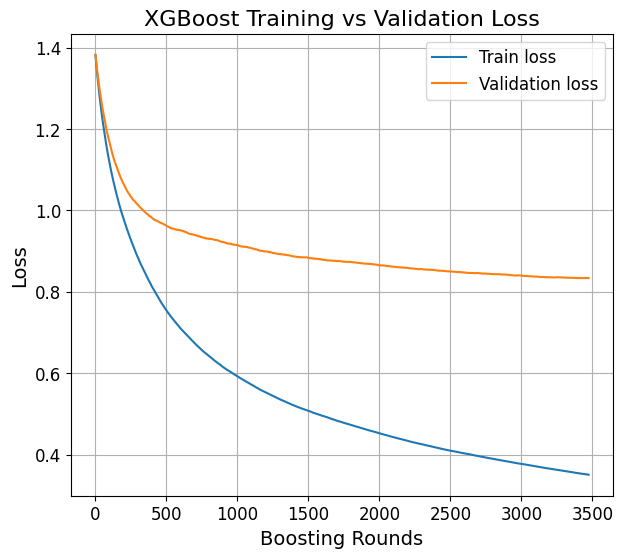


 Per-band evaluation:

--- Band = G ---
Count: 152
Accuracy: 0.5986842105263158
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        72
           1       0.00      0.00      0.00         8
           2       0.65      0.75      0.70        61
           3       0.15      0.27      0.19        11

    accuracy                           0.60       152
   macro avg       0.41      0.40      0.40       152
weighted avg       0.68      0.60      0.62       152

Confusion matrix:
 [[42  8 14  8]
 [ 3  0  4  1]
 [ 3  4 46  8]
 [ 1  0  7  3]]

--- Band = g' ---
Count: 36
Accuracy: 0.5833333333333334
              precision    recall  f1-score   support

           0       0.88      0.62      0.73        24
           1       0.11      0.50      0.18         2
           2       0.50      0.56      0.53         9
           3       0.00      0.00      0.00         1

    accuracy                           0.58        36
   macro avg       0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [335]:
# Model 2 with downsampling
II_bdt_down = XGBClassifier(
    n_estimators=5000,
    learning_rate=0.005,
    max_depth=3,
    min_child_weight=3,
    subsample=0.6,
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    early_stopping_rounds=50
)

II_bdt_down.fit(II_X_train_down, II_y_train_down,
                sample_weight=II_sample_weights_down,
                eval_set=[(II_X_train_down, II_y_train_down),(II_X_val_down, II_y_val_down)],
                verbose=False)
evaluate_model(II_bdt_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_band_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

Conclusion:
- Data preprocessing is very important, which in our case is necessary to handle outliers and the extreme difference between the scales of the features.
- Model 2 outperforms Model 1 even though it has less data. Probably because it has more features and accounts for double peak light curves
- Model 1 seems to extract features very well for type IIn supernovae, evidenced by generally better AUC than other classes.
- Downsampling does not improve classification. The reason might be that our downsampling process results in a too small dataset, making it difficult for the classifiers to learn.
